In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
from matplotlib.ticker import FormatStrFormatter

import result_utils

In [ ]:
name_A = 'Luhman 16A'; name_B = 'Luhman 16B'
color_A = '#FF622E'; color_B = '#396ED8'

lw_d = 0.8
lw_m = 1.0

cmap = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_A])
env_colors_A = cmap([0,1/4,2/4,3/4,1])
env_colors_A[:,3] = 0.5; env_colors_A[0,3] = 0.0

cmap = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_B])
env_colors_B = cmap([0,1/4,2/4,3/4,1])
env_colors_B[:,3] = 0.5; env_colors_B[0,3] = 0.0

res_alpha = 0.85

path = '/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs'
A = result_utils.RetrievalResults(f'{path}/freechem_K_A_ret_6/test_')
B = result_utils.RetrievalResults(f'{path}/freechem_K_B_ret_6/test_')

/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_A_ret_6/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_A_ret_6/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_B_ret_6/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_B_ret_6/test_.txt


: 

In [ ]:
A_wo_h2_18o = result_utils.RetrievalResults(f'{path}/freechem_K_A_ret_6_wo_h2_18o/test_')
A_wo_c18o = result_utils.RetrievalResults(f'{path}/freechem_K_A_ret_6_wo_c18o/test_')
B_wo_h2_18o = result_utils.RetrievalResults(f'{path}/freechem_K_B_ret_6_wo_h2_18o/test_')
B_wo_c18o = result_utils.RetrievalResults(f'{path}/freechem_K_B_ret_6_wo_c18o/test_')

A.compare_evidence(A_wo_h2_18o)
A.compare_evidence(A_wo_c18o)
B.compare_evidence(B_wo_h2_18o)
B.compare_evidence(B_wo_c18o)

/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_A_ret_6_wo_h2_18o/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_A_ret_6_wo_h2_18o/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_A_ret_6_wo_c18o/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_A_ret_6_wo_c18o/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_B_ret_6_wo_h2_18o/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_B_ret_6_wo_h2_18o/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_B_ret_6_wo_c18o/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_B_ret_6_wo_c18o/test_.txt
Current vs. given: ln(B)=11.99 | sigma=5.26
Given vs. current: ln(B)=-11.99 | sigma=nan
Current vs. give

(2.883343682334817, 2.0591956059553698)

: 

In [3]:
import copy

def get_CCF(Res, line_species_to_exclude=['1H2-16O__POKAZATEL', '1H2-17O__HotWat78', '12C-16O__HITEMP', '12C-17O__HITEMP', '1H-12C-14N__Harris']):
    
    Res.load_components(['Chem'])
    m_set = Res.model_settings[0]
    all_line_species = np.array(Res.Chem[m_set].line_species)

    #Res.get_model_spectrum(line_species_to_exclude=None, apply_rot_broad=False)
    Res.load_components(['m_spec_broad'])
    m_spec_broad_init = copy.deepcopy(Res.m_spec_broad)

    all_CCF, all_ACF = {}, {}
    
    for line_species in all_line_species:
        
        print('\n'+line_species)
        if line_species in ['MMW','H2','He']:
            continue

        if line_species in line_species_to_exclude:
            continue

        # Model w/o species X
        Res.get_model_spectrum(line_species_to_exclude=[line_species])
        m_spec_to_subtract = copy.deepcopy(Res.m_spec_broad)

        # Model w/o all other species
        # line_species_to_exclude = all_line_species[all_line_species != line_species]
        # Res.get_model_spectrum(line_species_to_exclude=line_species_to_exclude)#, apply_rot_broad=False)
        # m_spec_template = copy.deepcopy(Res.m_spec_broad)

        #Res.get_model_spectrum(line_species_to_exclude=[line_species], apply_rot_broad=False)
        #m_spec_to_subtract_from_template = copy.deepcopy(Res.m_spec_broad)

        m_spec_template = copy.deepcopy(Res.m_spec_broad)
        for m_set in Res.model_settings:
            m_spec_template[m_set].flux = [
                m_spec_broad_init[m_set].flux[i] - m_spec_to_subtract[m_set].flux[i] \
                for i in range(len(m_spec_broad_init[m_set].flux))
                ]

        kwargs = dict(
            filter_type='savgol', window_length=501, polyorder=2, mode='interp', 
            )
        rv, CCF, ACF = Res.get_CCF(
            m_spec_template=m_spec_template, 
            m_spec_to_subtract=m_spec_to_subtract, 
            high_pass_filter={
                #'m_res': result_utils.HighPassFilter(), # Filter on model
                #'d_res': result_utils.HighPassFilter(), # Filter on data
                #'m_res': result_utils.HighPassFilter(filter_type='nanmedian', size=301), # Filter on model
                #'d_res': result_utils.HighPassFilter(filter_type='nanmedian', size=301), # Filter on data
                'm_res': result_utils.HighPassFilter(**kwargs), # Filter on model
                'd_res': result_utils.HighPassFilter(**kwargs), # Filter on data
                },
            # rv=np.arange(-1000,1000,2),
            # rv=np.arange(-500,500,2),
            #plot=True, 
            )
        all_CCF[line_species] = CCF
        all_ACF[line_species] = ACF

        plt.figure(figsize=(5,2))
        plt.plot(rv, CCF.sum(axis=-1))
        plt.plot(rv, ACF.sum(axis=-1), ls=':')
        plt.show()

    return rv, all_CCF, all_ACF

rv, all_CCF_A, all_ACF_A = get_CCF(A)
rv, all_CCF_B, all_ACF_B = get_CCF(B)


1H2-16O__POKAZATEL

1H2-18O__HotWat78


: 

: 

In [ ]:
rv_A = A.ParamTable.get('rv')
rv_B = B.ParamTable.get('rv')
rv_A, rv_B = 0., 0.

# xlim = (0,1000)
# xlim = (-220,220)
xlim = (-310,310)
# xticks_minor = np.arange(-200,201,50)
# xticks = np.arange(-150,151,150)
xticks_minor = np.arange(-300,301,50)
# xticks = np.arange(-300,301,150)
xticks = np.arange(-200,201,200)

ylim = [(-8,32), (-4,13), (-4,10), (-4,7)]
yticks_minor = np.arange(-5,31,5)
#yticks = np.arange(0,31,10)
lw_m = 1.4

'''
species_to_plot = np.array([
    [('1H-19F__Coxon-Hajig', 'HF', '#FF59B4'), ('12C-1H4__MM', 'CH_4', 'C4')], 
    [('14N-1H3__CoYuTe', 'NH_3', 'C8'), ('1H2-32S__AYT2', 'H_2S', '#135D64')],
    # [('13C-16O__HITEMP', '^{13}CO', 'sienna'), None],
    [('13C-16O__HITEMP', '^{13}CO', 'sienna'), ('12C-16O2__HITEMP', 'CO_2', 'C7')],
    [('1H2-18O__HotWat78', 'H_2^{18}O', 'darkcyan'), ('12C-18O__HITEMP', 'C^{18}O', 'maroon')]
    # [('1H2-18O__HotWat78', 'H_2^{18}O', 'darkcyan'), ('12C-16O2__HITEMP', 'CO_2', 'maroon')]
], dtype=object)
'''
species_to_plot = np.array([
    [('1H-19F__Coxon-Hajig', 'HF', '#FF59B4'), ('12C-1H4__MM', 'CH_4', 'C4')], 
    [('14N-1H3__CoYuTe', 'NH_3', 'C8'), ('13C-16O__HITEMP', '^{13}CO', 'sienna')],
    [('1H2-32S__AYT2', 'H_2S', '#135D64'), ('12C-16O2__HITEMP', 'CO_2', 'C7')],
    [('1H2-18O__HotWat78', 'H_2^{18}O', 'darkcyan'), ('12C-18O__HITEMP', 'C^{18}O', 'maroon')]
], dtype=object)

fig = plt.figure(figsize=(9,3.3))
gs = fig.add_gridspec(nrows=2, ncols=5, hspace=0.08, wspace=0.05, width_ratios=[1,1,0.13,1,1])
ax = np.array([
    [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])],
    [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])],
    [fig.add_subplot(gs[0,3]), fig.add_subplot(gs[0,4])],
    [fig.add_subplot(gs[1,3]), fig.add_subplot(gs[1,4])],
    ])

for i, species_row in enumerate(species_to_plot):
    for j, items in enumerate(species_row):
        
        if items is None:
            ax[i,j].set_axis_off()
            handle_A, = ax[i,j].plot(np.nan, np.nan, color=color_A, lw=lw_m)
            handle_B, = ax[i,j].plot(np.nan, np.nan, color=color_B, lw=lw_m, ls=(0,(3,2)))
            ax[i,j].legend(
                loc='lower center', bbox_to_anchor=(0.5,-0.05), frameon=False, 
                handles=[handle_A,handle_B], labels=['Luhman 16A', 'Luhman 16B'], 
                markerfirst=False, handlelength=1.5, handletextpad=0.5, 
                labelcolor='linecolor', prop={'weight':'bold', 'size':13}, 
            )

            #ax[4].set(xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$', ylabel='CCF S/N')
            continue
        line_species_j, label_j, color_j = items

        CCF_SNR_A = result_utils.convert_CCF_to_SNR(rv, all_CCF_A[line_species_j][:,:].sum(axis=-1), rv_sep=300)
        CCF_SNR_B = result_utils.convert_CCF_to_SNR(rv, all_CCF_B[line_species_j][:,:].sum(axis=-1), rv_sep=300)
        ax[i,j].plot(rv+rv_A, CCF_SNR_A, lw=lw_m, c=color_j)
        ax[i,j].plot(rv+rv_B, CCF_SNR_B, lw=lw_m, c=color_j, ls=(0,(3,2)))

        # Reference lines
        ax[i,j].axhline(0, lw=0.8, c='k', zorder=-1, alpha=0.3)
        ax[i,j].axvline(0, lw=0.8, c='k', zorder=-1, alpha=0.3)

        # Print SNR in corner
        sigma_A = f'{CCF_SNR_A[rv==0].flatten()[0]:.1f}'
        sigma_B = f'{CCF_SNR_B[rv==0].flatten()[0]:.1f}'
        if len(sigma_A)==4:
            sigma_A = f'{CCF_SNR_A[rv==0].flatten()[0]:.0f}'
        if len(sigma_B)==4:
            sigma_B = f'{CCF_SNR_B[rv==0].flatten()[0]:.0f}'

        sigma_A = r'${'+sigma_A+r'\sigma}$'
        sigma_B = r'${'+sigma_B+r'\sigma}$'
        ax[i,j].annotate(
            sigma_A, xy=(14,CCF_SNR_A[rv==0].flatten()[0]), xytext=(0.95,0.92), 
            textcoords='axes fraction', ha='right', va='top', color=color_A, fontsize=12, 
            arrowprops=dict(
                arrowstyle='-', lw=1, color=color_A, 
                connectionstyle='arc,angleA=180,angleB=0,armA=25,armB=9,rad=3', 
                )
            )
        ax[i,j].annotate(
            sigma_B, xy=(14,CCF_SNR_B[rv==0].flatten()[0]), xytext=(0.95,0.76), 
            textcoords='axes fraction', ha='right', va='top', color=color_B, fontsize=12, 
            arrowprops=dict(
                arrowstyle='-', lw=1, color=color_B, ls=(0,(4,3)), 
                connectionstyle='arc,angleA=180,angleB=0,armA=25,armB=9,rad=3', 
                )
            )

        # Print molecule name in corner
        label_j = r'$\mathrm{\bf '+f'{label_j}'+'}$'
        ax[i,j].annotate(
            label_j, xy=(0.05,0.92), xycoords='axes fraction', ha='left', va='top', color=color_j, fontsize=13
            )

        # Ticks and labels
        ax[i,j].set_yticks(yticks_minor, minor=True)
        ax[i,j].set_xticks(xticks_minor, minor=True)
        ax[i,j].set(xlim=xlim, ylim=ylim[i], xticks=xticks)#, xticks_minor=xticks_minor)
        
        if j != 0:
            ax[i,j].set_yticklabels([])

        if i in [0,2]:
            ax[i,j].set_xticklabels([])

        # ACF_SNR_A = result_utils.convert_CCF_to_SNR(rv, all_ACF_A[line_species_j][:,:].sum(axis=-1), rv_sep=300)
        # ACF_SNR_B = result_utils.convert_CCF_to_SNR(rv, all_ACF_B[line_species_j][:,:].sum(axis=-1), rv_sep=300)
        # ax[i,j].plot(rv+rv_A, ACF_SNR_A, lw=lw_m, c=color_j, ls=':')
        # ax[i,j].plot(rv+rv_B, ACF_SNR_B, lw=lw_m, c=color_j, ls=':')

ax_leg = fig.add_subplot(gs[0,2])
ax_leg.set_axis_off()
handle_A, = ax[0,0].plot(np.nan, np.nan, color=color_A, lw=lw_m)
handle_B, = ax[0,0].plot(np.nan, np.nan, color=color_B, lw=lw_m, ls=(0,(3,2)))
ax[0,0].legend(
    loc='lower center', bbox_to_anchor=(1,1), frameon=False, ncols=2, 
    handles=[handle_A,handle_B], labels=['Luhman 16A', 'Luhman 16B'], 
    handlelength=1.5, handletextpad=0.5, borderaxespad=0., 
    labelcolor='linecolor', prop={'weight':'bold', 'size':13}, 
)

ax[1,0].set(ylabel=r'CCF S/N', xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$')
ax[3,0].set(xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$')

plt.subplots_adjust(left=0.06, bottom=0.17, top=0.89, right=0.98)
plt.savefig(f'./plots/K_band_CCF.pdf')
plt.show()

NameError: name 'A' is not defined

In [ ]:
rv_A = A.ParamTable.get('rv')
rv_B = B.ParamTable.get('rv')
rv_A, rv_B = 0., 0.

# xlim = (0,1000)
# xlim = (-220,220)
xlim = (-310,310)
# xticks_minor = np.arange(-200,201,50)
# xticks = np.arange(-150,151,150)
xticks_minor = np.arange(-300,301,50)
# xticks = np.arange(-300,301,150)
xticks = np.arange(-200,201,200)

ylim = [(-8,32), (-4,13), (-4,10), (-4,7)]
yticks_minor = np.arange(-5,31,5)
#yticks = np.arange(0,31,10)
lw_m = 1.4

'''
species_to_plot = np.array([
    [('1H-19F__Coxon-Hajig', 'HF', '#FF59B4'), ('12C-1H4__MM', 'CH_4', 'C4')], 
    [('14N-1H3__CoYuTe', 'NH_3', 'C8'), ('1H2-32S__AYT2', 'H_2S', '#135D64')],
    # [('13C-16O__HITEMP', '^{13}CO', 'sienna'), None],
    [('13C-16O__HITEMP', '^{13}CO', 'sienna'), ('12C-16O2__HITEMP', 'CO_2', 'C7')],
    [('1H2-18O__HotWat78', 'H_2^{18}O', 'darkcyan'), ('12C-18O__HITEMP', 'C^{18}O', 'maroon')]
    # [('1H2-18O__HotWat78', 'H_2^{18}O', 'darkcyan'), ('12C-16O2__HITEMP', 'CO_2', 'maroon')]
], dtype=object)
'''
species_to_plot = np.array([
    [('1H-19F__Coxon-Hajig', 'HF', '#FF59B4'), ('12C-1H4__MM', 'CH_4', 'C4')], 
    [('14N-1H3__CoYuTe', 'NH_3', 'C8'), ('13C-16O__HITEMP', '^{13}CO', 'sienna')],
    [('1H2-32S__AYT2', 'H_2S', '#135D64'), ('12C-16O2__HITEMP', 'CO_2', 'C7')],
    [('1H2-18O__HotWat78', 'H_2^{18}O', 'darkcyan'), ('12C-18O__HITEMP', 'C^{18}O', 'maroon')]
], dtype=object)

fig = plt.figure(figsize=(4.5,6.5))
gs = fig.add_gridspec(nrows=4, ncols=2, hspace=0.08, wspace=0.05)
ax = np.array([
    [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])],
    [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])],
    [fig.add_subplot(gs[2,0]), fig.add_subplot(gs[2,1])],
    [fig.add_subplot(gs[3,0]), fig.add_subplot(gs[3,1])],
    ])

for i, species_row in enumerate(species_to_plot):
    for j, items in enumerate(species_row):
        
        if items is None:
            ax[i,j].set_axis_off()
            handle_A, = ax[i,j].plot(np.nan, np.nan, color=color_A, lw=lw_m)
            handle_B, = ax[i,j].plot(np.nan, np.nan, color=color_B, lw=lw_m, ls=(0,(3,2)))
            ax[i,j].legend(
                loc='lower center', bbox_to_anchor=(0.5,-0.05), frameon=False, 
                handles=[handle_A,handle_B], labels=['Luhman 16A', 'Luhman 16B'], 
                markerfirst=False, handlelength=1.5, handletextpad=0.5, 
                labelcolor='linecolor', prop={'weight':'bold', 'size':13}, 
            )

            #ax[4].set(xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$', ylabel='CCF S/N')
            continue
        line_species_j, label_j, color_j = items

        CCF_SNR_A = result_utils.convert_CCF_to_SNR(rv, all_CCF_A[line_species_j][:,:].sum(axis=-1), rv_sep=300)
        CCF_SNR_B = result_utils.convert_CCF_to_SNR(rv, all_CCF_B[line_species_j][:,:].sum(axis=-1), rv_sep=300)
        ax[i,j].plot(rv+rv_A, CCF_SNR_A, lw=lw_m, c=color_j)
        ax[i,j].plot(rv+rv_B, CCF_SNR_B, lw=lw_m, c=color_j, ls=(0,(3,2)))

        # Reference lines
        ax[i,j].axhline(0, lw=0.8, c='k', zorder=-1, alpha=0.3)
        ax[i,j].axvline(0, lw=0.8, c='k', zorder=-1, alpha=0.3)

        # Print SNR in corner
        sigma_A = f'{CCF_SNR_A[rv==0].flatten()[0]:.1f}'
        sigma_B = f'{CCF_SNR_B[rv==0].flatten()[0]:.1f}'
        if len(sigma_A)==4:
            sigma_A = f'{CCF_SNR_A[rv==0].flatten()[0]:.0f}'
        if len(sigma_B)==4:
            sigma_B = f'{CCF_SNR_B[rv==0].flatten()[0]:.0f}'

        sigma_A = r'${'+sigma_A+r'\sigma}$'
        sigma_B = r'${'+sigma_B+r'\sigma}$'
        ax[i,j].annotate(
            sigma_A, xy=(14,CCF_SNR_A[rv==0].flatten()[0]), xytext=(0.95,0.92), 
            textcoords='axes fraction', ha='right', va='top', color=color_A, fontsize=12, 
            arrowprops=dict(
                arrowstyle='-', lw=1, color=color_A, 
                connectionstyle='arc,angleA=180,angleB=0,armA=25,armB=9,rad=3', 
                )
            )
        ax[i,j].annotate(
            sigma_B, xy=(14,CCF_SNR_B[rv==0].flatten()[0]), xytext=(0.95,0.76), 
            textcoords='axes fraction', ha='right', va='top', color=color_B, fontsize=12, 
            arrowprops=dict(
                arrowstyle='-', lw=1, color=color_B, ls=(0,(4,3)), 
                connectionstyle='arc,angleA=180,angleB=0,armA=25,armB=9,rad=3', 
                )
            )

        # Print molecule name in corner
        label_j = r'$\mathrm{\bf '+f'{label_j}'+'}$'
        ax[i,j].annotate(
            label_j, xy=(0.05,0.92), xycoords='axes fraction', ha='left', va='top', color=color_j, fontsize=13
            )

        # Ticks and labels
        ax[i,j].set_yticks(yticks_minor, minor=True)
        ax[i,j].set_xticks(xticks_minor, minor=True)
        ax[i,j].set(xlim=xlim, ylim=ylim[i], xticks=xticks)#, xticks_minor=xticks_minor)
        
        if j != 0:
            ax[i,j].set_yticklabels([])

        if i in [0,2]:
            ax[i,j].set_xticklabels([])

        # ACF_SNR_A = result_utils.convert_CCF_to_SNR(rv, all_ACF_A[line_species_j][:,:].sum(axis=-1), rv_sep=300)
        # ACF_SNR_B = result_utils.convert_CCF_to_SNR(rv, all_ACF_B[line_species_j][:,:].sum(axis=-1), rv_sep=300)
        # ax[i,j].plot(rv+rv_A, ACF_SNR_A, lw=lw_m, c=color_j, ls=':')
        # ax[i,j].plot(rv+rv_B, ACF_SNR_B, lw=lw_m, c=color_j, ls=':')

ax_leg = fig.add_subplot(gs[0,2])
ax_leg.set_axis_off()
handle_A, = ax[0,0].plot(np.nan, np.nan, color=color_A, lw=lw_m)
handle_B, = ax[0,0].plot(np.nan, np.nan, color=color_B, lw=lw_m, ls=(0,(3,2)))
ax[0,0].legend(
    loc='lower center', bbox_to_anchor=(1,1), frameon=False, ncols=2, 
    handles=[handle_A,handle_B], labels=['Luhman 16A', 'Luhman 16B'], 
    handlelength=1.5, handletextpad=0.5, borderaxespad=0., 
    labelcolor='linecolor', prop={'weight':'bold', 'size':13}, 
)

ax[1,0].set(ylabel=r'CCF S/N', xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$')
ax[3,0].set(xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$')

plt.subplots_adjust(left=0.06, bottom=0.17, top=0.89, right=0.98)
plt.savefig(f'./plots/K_band_CCF.pdf')
plt.show()

<>:70: SyntaxWarning: invalid escape sequence '\m'
<>:70: SyntaxWarning: invalid escape sequence '\m'
/var/tmp/regt/ipykernel_498697/3183870131.py:70: SyntaxWarning: invalid escape sequence '\m'
  '''


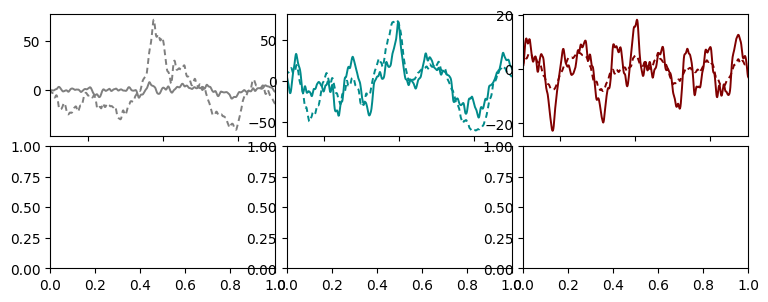

"\nax = np.array([\n    [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])],\n    [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])],\n    [fig.add_subplot(gs[0,3]), fig.add_subplot(gs[0,4])],\n    [fig.add_subplot(gs[1,3]), fig.add_subplot(gs[1,4])],\n    ])\n\nfor i, species_row in enumerate(species_to_plot):\n    for j, items in enumerate(species_row):\n        \n        if items is None:\n            ax[i,j].set_axis_off()\n            handle_A, = ax[i,j].plot(np.nan, np.nan, color=color_A, lw=lw_m)\n            handle_B, = ax[i,j].plot(np.nan, np.nan, color=color_B, lw=lw_m, ls=(0,(3,2)))\n            ax[i,j].legend(\n                loc='lower center', bbox_to_anchor=(0.5,-0.05), frameon=False, \n                handles=[handle_A,handle_B], labels=['Luhman 16A', 'Luhman 16B'], \n                markerfirst=False, handlelength=1.5, handletextpad=0.5, \n                labelcolor='linecolor', prop={'weight':'bold', 'size':13}, \n            )\n\n            continue\n        lin

In [78]:
def bootstrap_CCF_SNR(rv, CCF, ax=None, **plot_kwargs):

    from astropy.modeling.models import Gaussian1D, Const1D
    from astropy.modeling import fitting
    
    amplitude = CCF[rv==0]
    m_init = (
        Gaussian1D(amplitude=amplitude, stddev=10, fixed={'mean':True}) + Const1D(amplitude=0)
    )
    fit = fitting.LevMarLSQFitter()
    m_fit = fit(m_init, rv, CCF)

    # fig2, ax2 = plt.subplots(figsize=(5,2))
    # ax2.plot(rv, CCF, lw=0.8, c='k')
    # ax2.plot(rv, m_fit(rv), lw=1.4, c='r')
    # # ax2.plot(rv, CCF_residuals, 'k--', lw=0.8, alpha=0.5)
    # ax2.set(xlim=(-300,300))
    # fig2.show()

    if ax is not None:
        ax.plot(rv, CCF, 'k-', lw=lw_m)
        ax.plot(rv, m_fit(rv), 'r-', lw=lw_m)
        ax.plot(rv, CCF - m_fit(rv), 'k--', lw=lw_m)

    m_fit.amplitude_1 = 0. # Remove vertical offset

    CCF_residuals = CCF - m_fit(rv)
    m_fit_shifted = m_fit.copy()

    SNRs = np.zeros_like(rv, dtype=float)
    for rv_i in rv:
        # Inject peak at another velocity
        m_fit_shifted.mean_0 = m_fit.mean_0 + rv_i
        CCF_shifted = CCF_residuals + m_fit_shifted(rv)

        # Calculate SNR
        SNR_i = result_utils.convert_CCF_to_SNR(rv, CCF_shifted, rv_sep=300, rv_0=rv_i)
        SNRs[rv==rv_i] = SNR_i[rv==rv_i]

    return SNRs

xlim = (-3,12)

fig = plt.figure(figsize=(9,3.3))
gs = fig.add_gridspec(nrows=2, ncols=3, hspace=0.08, wspace=0.05, width_ratios=[1,1,1])
ax_CCF = np.array([fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,2])])
ax_hist = np.array([fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1]), fig.add_subplot(gs[1,2])])


species = [
    ('12C-16O2__HITEMP', 'CO_2', 'C7'), 
    ('1H2-18O__HotWat78', 'H_2^{18}O', 'darkcyan'), 
    ('12C-18O__HITEMP', 'C^{18}O', 'maroon')
]
for j, items in enumerate(species):
    line_species_j, label_j, color_j = items

    CCF_A = all_CCF_A[line_species_j][:,:].sum(axis=-1)
    CCF_B = all_CCF_B[line_species_j][:,:].sum(axis=-1)

    SNR_CCF_A = result_utils.convert_CCF_to_SNR(rv, CCF_A, rv_sep=300)
    SNR_CCF_B = result_utils.convert_CCF_to_SNR(rv, CCF_B, rv_sep=300)

    ax_CCF[j].plot(rv+rv_A, CCF_A, lw=lw_m, c=color_j)
    ax_CCF[j].plot(rv+rv_B, CCF_B, lw=lw_m, c=color_j, ls=(0,(3,2)))

    ax_CCF[j].set(xlim=(-300,300))

plt.show()
'''
ax = np.array([
    [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])],
    [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])],
    [fig.add_subplot(gs[0,3]), fig.add_subplot(gs[0,4])],
    [fig.add_subplot(gs[1,3]), fig.add_subplot(gs[1,4])],
    ])

for i, species_row in enumerate(species_to_plot):
    for j, items in enumerate(species_row):
        
        if items is None:
            ax[i,j].set_axis_off()
            handle_A, = ax[i,j].plot(np.nan, np.nan, color=color_A, lw=lw_m)
            handle_B, = ax[i,j].plot(np.nan, np.nan, color=color_B, lw=lw_m, ls=(0,(3,2)))
            ax[i,j].legend(
                loc='lower center', bbox_to_anchor=(0.5,-0.05), frameon=False, 
                handles=[handle_A,handle_B], labels=['Luhman 16A', 'Luhman 16B'], 
                markerfirst=False, handlelength=1.5, handletextpad=0.5, 
                labelcolor='linecolor', prop={'weight':'bold', 'size':13}, 
            )

            continue
        line_species_j, label_j, color_j = items

        # fig2, ax2 = plt.subplots(figsize=(7,4))
        # for k in range(all_CCF_A[line_species_j].shape[1]):
        #     c = f'C{k}'
        #     if k >= 18:
        #         c = 'k'
        #     CCF = all_CCF_A[line_species_j][:,k]
        #     ax2.plot(rv, CCF, lw=1.2, c=c)
        #     # CCF = all_CCF_B[line_species_j][:,k]
        #     # ax2.plot(rv, CCF, lw=1.2, c=c, ls=(0,(3,2)))
        # ax2.set(xlim=(-300,300))
        # fig2.show()
        
        SNRs_A = bootstrap_CCF_SNR(rv, all_CCF_A[line_species_j][:,:].sum(axis=-1))
        SNRs_B = bootstrap_CCF_SNR(rv, all_CCF_B[line_species_j][:,:].sum(axis=-1))
        print(label_j)
        result_utils.latex_format(SNRs_A, SNRs_B, q=result_utils.q[0], decimals=2)

        ax[i,j].hist(SNRs_A, bins=50, histtype='stepfilled', fc=color_A, ec=color_A, alpha=0.5, lw=lw_m, range=xlim, density=True)
        ax[i,j].hist(SNRs_B, bins=50, histtype='stepfilled', fc=color_B, ec=color_B, alpha=0.5, lw=lw_m, range=xlim, density=True)

        CCF_SNR_A = result_utils.convert_CCF_to_SNR(rv, all_CCF_A[line_species_j][:,:].sum(axis=-1), rv_sep=300)
        CCF_SNR_B = result_utils.convert_CCF_to_SNR(rv, all_CCF_B[line_species_j][:,:].sum(axis=-1), rv_sep=300)
        sigma_A = CCF_SNR_A[rv==0].flatten()[0]
        sigma_B = CCF_SNR_B[rv==0].flatten()[0]

        ax[i,j].axvline(sigma_A, lw=1.4, c=color_A)
        ax[i,j].axvline(sigma_B, lw=1.4, c=color_B, ls=(0,(3,2)))
        

        # Print molecule name in corner
        label_j = r'$\mathrm{\bf '+f'{label_j}'+'}$'
        ax[i,j].annotate(
            label_j, xy=(0.05,0.92), xycoords='axes fraction', ha='left', va='top', color=color_j, fontsize=13
            )

        # Ticks and labels
        ax[i,j].set(xlim=xlim)
        if j != 0:
            ax[i,j].set_yticklabels([])
        if i in [0,2]:
            ax[i,j].set_xticklabels([])

# ax[1,0].set(ylabel=r'CCF S/N', xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$')
# ax[3,0].set(xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$')

plt.subplots_adjust(left=0.06, bottom=0.17, top=0.89, right=0.98)
# plt.savefig(f'./plots/K_band_CCF.pdf')
plt.show()
'''

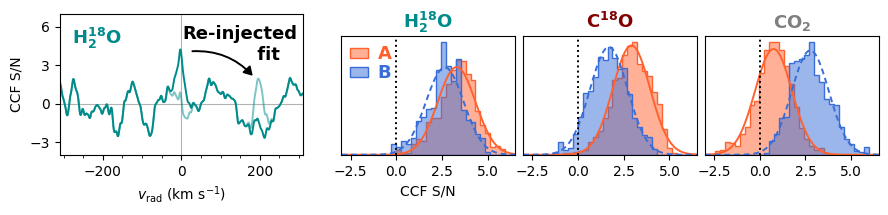

In [244]:
def bootstrap_CCF_SNR(rv, CCF):

    from astropy.modeling.models import Gaussian1D, Const1D, Moffat1D
    from astropy.modeling import fitting
    
    amplitude = CCF[rv==0]
    m_init = (
        # Moffat1D(amplitude=amplitude, alpha=2, gamma=10, fixed={'x_0':True}) + Const1D(amplitude=0)
        Gaussian1D(amplitude=amplitude, stddev=10, fixed={'mean':True}) + Const1D(amplitude=0)
        # Gaussian1D(amplitude=amplitude, stddev=10, bounds={'mean':(-20,20)}) + Const1D(amplitude=0)
    )
    fit = fitting.LevMarLSQFitter()
    m_fit = fit(m_init, rv, CCF)
    # print(m_fit[0].stddev)
    # print(m_fit[0].mean)
    # m_fit[0].amplitude *= 0.8

    CCF_residuals = CCF - m_fit[0](rv)
    m_fit_shifted = m_fit[0].copy() # Remove vertical offset

    SNRs = []
    # for rv_i in rv[(rv>-500) & (rv<500)]:
    for rv_i in rv:
        # Inject peak at another velocity
        m_fit_shifted.mean = m_fit[0].mean + rv_i
        # m_fit_shifted.x_0 = m_fit[0].x_0 + rv_i
        CCF_shifted = CCF_residuals + m_fit_shifted(rv)

        # Calculate SNR
        SNR_i = result_utils.convert_CCF_to_SNR(rv, CCF_shifted, rv_sep=300, rv_0=rv_i)
        SNRs.append(SNR_i[rv==rv_i])

    return np.array(SNRs), m_fit

hist_kwargs_A = dict(
    #bins=25, histtype='stepfilled', fc=env_colors_m_A[1], ec=color_m_A, lw=2, bottom=0, density=True
    bins=35, histtype='stepfilled', fc=env_colors_A[-1], ec=color_A, lw=lw_m, bottom=0, density=True
)

hist_kwargs_B = hist_kwargs_A.copy()
hist_kwargs_B['fc'] = env_colors_B[-1]
hist_kwargs_B['ec'] = color_B

xlim = (-3,6.5)

from scipy.stats import norm
x = np.linspace(xlim[0], xlim[1], 100)

fig = plt.figure(figsize=(9,2.2))
gs = fig.add_gridspec(nrows=2, ncols=5, wspace=0.05, width_ratios=[1.4,0.13,1,1,1], height_ratios=[0.08,1])
ax_CCF = np.array([fig.add_subplot(gs[:,0])])
ax_hist = np.array([fig.add_subplot(gs[1,-3]), fig.add_subplot(gs[1,-2]), fig.add_subplot(gs[1,-1])])

species = [
    ('1H2-18O__HotWat78', 'H_2^{18}O', 'darkcyan'), 
    ('12C-18O__HITEMP', 'C^{18}O', 'maroon'), 
    ('12C-16O2__HITEMP', 'CO_2', 'C7'), 
]
for j, items in enumerate(species):
    line_species_j, label_j, color_j = items
    label_j = r'$\mathrm{\bf '+f'{label_j}'+'}$'

    CCF_A = all_CCF_A[line_species_j][:,:].sum(axis=-1)
    CCF_B = all_CCF_B[line_species_j][:,:].sum(axis=-1)
    
    SNRs_A, m_fit = bootstrap_CCF_SNR(rv, CCF_A)
    SNRs_B, _ = bootstrap_CCF_SNR(rv, CCF_B)

    if j == 0:
        # ax_CCF[j].plot(rv, CCF_A, lw=lw_m, c=color_j)
        # # ax_CCF[j].plot(rv, m_fit[0](rv), lw=lw_m, c='k', ls='--')
        # ax_CCF[j].plot(rv, CCF_A-m_fit[0](rv), lw=lw_m, c=color_j, ls='--')

        CCF_SNR_A = result_utils.convert_CCF_to_SNR(rv, CCF_A, rv_sep=300)
        ax_CCF[j].plot(rv+rv_A, CCF_SNR_A, lw=1.4, c=color_j)

        CCF_A_res = CCF_A - m_fit[0](rv)
        m_fit_shifted = m_fit[0].copy() # Remove vertical offset

        for rv_j in [200]:
            # Inject peak at another velocity            
            m_fit_shifted.mean = m_fit[0].mean + rv_j
            # m_fit_shifted.x_0 = m_fit[0].x_0 + rv_j
            CCF_A_shifted = CCF_A_res + m_fit_shifted(rv)        

            CCF_SNR_A = result_utils.convert_CCF_to_SNR(rv, CCF_A_shifted, rv_sep=300)
            ax_CCF[j].plot(rv+rv_A, CCF_SNR_A, lw=1.4, c=color_j, ls='-', alpha=0.5)

        # Reference lines
        ax_CCF[j].axhline(0, lw=0.8, c='k', zorder=-1, alpha=0.3)
        ax_CCF[j].axvline(0, lw=0.8, c='k', zorder=-1, alpha=0.3)

        # Print molecule name in corner
        ax_CCF[j].annotate(
            label_j, xy=(0.05,0.92), xycoords='axes fraction', ha='left', va='top', 
            color=color_j, fontsize=13, fontweight='bold', 
            )

    ax_hist[j].hist(SNRs_A, range=xlim, label='A', **hist_kwargs_A)
    ax_hist[j].hist(SNRs_B, range=xlim, label='B', **hist_kwargs_B)
    
    y = norm.pdf(x, loc=np.mean(SNRs_A), scale=np.std(SNRs_A))
    ax_hist[j].plot(x, y, lw=1.4, c=color_A)
    y = norm.pdf(x, loc=np.mean(SNRs_B), scale=np.std(SNRs_B))
    ax_hist[j].plot(x, y, lw=1.4, c=color_B, ls=(0,(3,2)))
    
    # print(norm.cdf(0.0, loc=np.mean(SNRs_A), scale=np.std(SNRs_A))*100)
    # print(norm.cdf(0.0, loc=np.mean(SNRs_B), scale=np.std(SNRs_B))*100)
    # print(norm.ppf(0.01, loc=np.mean(SNRs_A), scale=np.std(SNRs_A)))
    # print(norm.ppf(0.01, loc=np.mean(SNRs_B), scale=np.std(SNRs_B)))
    print()

    ax_hist[j].set(xlim=xlim, yticks=[])

    # Reference lines
    # ax_hist[j].axvline(SNRs_A[rv==0].flatten()[0], lw=1.4, c=color_A)
    # ax_hist[j].axvline(SNRs_B[rv==0].flatten()[0], lw=1.4, c=color_B, ls=(0,(3,2)))
    ax_hist[j].axvline(0, lw=1.4, c='k', ls=':')
    
    # Print molecule name in corner
    ax_hist[j].set_title(label_j, fontsize=13, fontweight='bold', color=color_j)

ax_CCF[0].annotate(
    '', xy=(0,4), xytext=(200,1.5), ha='center', va='center', 
    arrowprops=dict(
        arrowstyle='<|-,head_width=0.3,head_length=0.5', shrinkB=8, shrinkA=8, 
        connectionstyle='arc3,rad=0.3', lw=1.4, color='k'
        )
    )
ax_CCF[0].annotate(
    'Re-injected\n         fit', xy=(150,4.6), ha='center', va='center', 
    color='k', fontsize=13, fontweight='bold', 
    )

ax_CCF[0].set_xticks(xticks_minor, minor=True)
ax_CCF[0].set(
    xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$', xlim=(-310,310), xticks=xticks, 
    ylabel='CCF S/N', ylim=(-4,7), yticks=(-3,0,3,6), 
    )

ax_hist[0].legend(
    loc='upper left', bbox_to_anchor=(0.,1.), labelspacing=0.05, handlelength=1.0, handleheight=0.5, 
    handletextpad=0.5, borderpad=0., labelcolor=[color_A, color_B], 
    prop={'weight':'bold', 'size':13}, frameon=False, 
)
ax_hist[0].set(xlabel='CCF S/N')

plt.subplots_adjust(left=0.07, bottom=0.25, top=0.89, right=0.98)
plt.savefig(f'./plots/K_band_bootstrap_CCF.pdf')

plt.show()